# The Separatrix Operational Space

Although `cfsPOPCON` is mainly designed for performing POPCON analyses, it is flexible enough to be applied for a range of different models. In this notebook, we show how `cfsPOPCON` can be used to reproduce the "SepOS" analysis in ["Eich, Manz and the ASDEX Upgrade Team, Nucl. Fusion 61 (2021) 086017, The separatrix operational space of ASDEX Upgrade due to interchange-drift-Alfvén turbulence"](https://doi.org/10.1088/1741-4326/ac0412).

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import cfspopcon
from cfspopcon.unit_handling import ureg

# Change to the top-level directory. Required to find radas_dir in its default location.
%cd {Path(cfspopcon.__file__).parents[1]}
# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

/Users/tbody/Code/cfspopcon
Running in /Users/tbody/Code/cfspopcon


We've set up an example case in `example_cases/AUG_SepOS`. To use this case, we load and run it just like a normal POPCON analysis.

In [2]:
input_parameters, algorithm, points, plots  = cfspopcon.read_case("example_cases/AUG_SepOS")
dataset = xr.Dataset(input_parameters)
dataset = algorithm.update_dataset(dataset)

That's already performed the computation! However, we want to make sure that we've implemented everything correctly. For this, we took a few points from the paper and will compare the results of our analysis with these results.

In [3]:
sepos_reference = cfspopcon.formulas.separatrix_conditions.separatrix_operational_space.read_AUG_SepOS_reference()

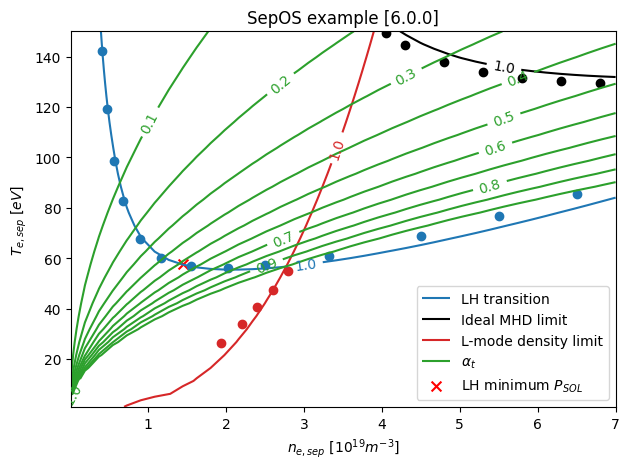

In [4]:
fig, ax = plt.subplots()

plot_style = cfspopcon.read_plot_style("example_cases/AUG_SepOS/plot_sepos.yaml")

cfspopcon.plotting.make_plot(
    dataset,
    plot_style,
    points=points,
    title="SepOS example",
    output_dir=None,
    ax=ax,
)

ax.scatter(
    sepos_reference["LH_transition"]["separatrix_density"], sepos_reference["LH_transition"]["separatrix_temp"],
    color="tab:blue"
)
ax.scatter(
    sepos_reference["density_limit"]["separatrix_density"], sepos_reference["density_limit"]["separatrix_temp"],
    color="tab:red"
)
ax.scatter(
    sepos_reference["MHD_limit"]["separatrix_density"], sepos_reference["MHD_limit"]["separatrix_temp"],
    color="black"
)

plt.show()

We can see that we're matching the result from the paper quite closely, and so we're confident that our algorithm is doing the right thing. We can also reproduce the results for the power crossing the separatrix.

Text(0.5, 1.0, '$P_{SOL,i} [MW]$')

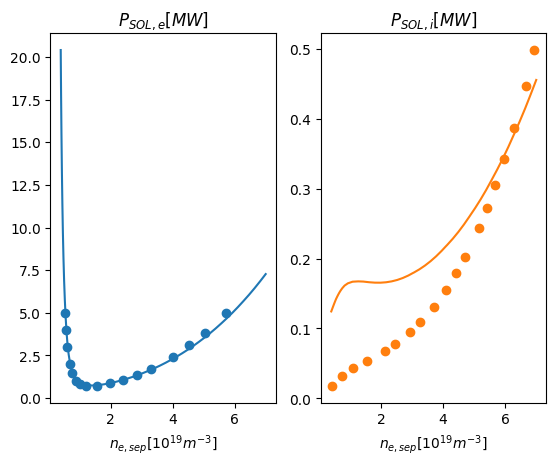

In [5]:
from cfspopcon.shaping_and_selection import find_coords_of_contour, interpolate_onto_line

fig, axs = plt.subplots(ncols=2)

axs[0].scatter(
    sepos_reference["LH_power_in_electron_channel"]["separatrix_density"], sepos_reference["LH_power_in_electron_channel"]["separatrix_power"],
    color="tab:blue"
)
axs[1].scatter(
    sepos_reference["LH_power_in_ion_channel"]["separatrix_density"], sepos_reference["LH_power_in_ion_channel"]["separatrix_power"],
    color="tab:orange"
)

contour_x, contour_y = find_coords_of_contour(dataset.SepOS_LH_transition,
                       x_coord="dim_separatrix_electron_density",
                       y_coord="dim_separatrix_electron_temp",
                       level=1.0
                       )

interpolate_onto_line(dataset.sustainment_power_in_electron_channel, contour_x, contour_y).plot(ax=axs[0])
interpolate_onto_line(dataset.sustainment_power_in_ion_channel, contour_x, contour_y).plot(ax=axs[1], color="tab:orange")

for ax in axs:
    ax.set_xlabel("$n_{e,sep} [10^{19}m^{-3}]$")
    ax.set_ylabel("")
axs[0].set_title("$P_{SOL,e} [MW]$")
axs[1].set_title("$P_{SOL,i} [MW]$")

Here, the power crossing the separatrix in the electron channel is reproduced quite closely. The power in the ion channel isn't matched so well, but this is due to a different assumption for $\chi_i$.